In [1]:
import numpy as np
import matplotlib.pyplot as plt
import fmt
import pandas as pd

from swap import Swap,priceSwap
from marketSetup import simulateOIS,simulateSurvivalProb
from valuationAdjustment import calculatePVEE,calculateUniCVA,calculateUniDVA,calculateNetUniCVA,calculateBiCVA,calculateBiDVA,calculateNetBiCVA


### 3 CVA/DVA Exercise

###### Simulate OIS curve

From equation (18) and (19) from [1], we get $$\sigma_{22}=\sigma_2$$
$$\sigma_{21}=\sigma_1 \times \rho_x$$
$$\sigma_{11}=\sqrt{\sigma_1^2-\sigma_{21}^2}=\sqrt{\sigma_1^2-\sigma_1^2\times \rho_x^2}$$
For $y(t)$, we calculate the involved integral manually:
$$\int_{0}^{t}{a(u)^T a(u)du}=\int_{0}^{t} \begin{bmatrix} \sigma_{11}^2e^{2\kappa_1u}+\sigma_{21}^2e^{2\kappa_1u} & \sigma_{21}\sigma_{22}e^{(\kappa_1+\kappa_2)u}\\\sigma_{21}\sigma_{22}e^{(\kappa_1+\kappa_2)u} & \sigma_{22}^2e^{2\kappa_2u} \end{bmatrix}du \\=\begin{bmatrix} \frac{\sigma_{11}^2+\sigma_{21}^2}{2\kappa_1}(e^{2\kappa_1t}-1) & \frac{\sigma_{21}\sigma_{22}}{\kappa_1+\kappa_2}(e^{(\kappa_1+\kappa_2)t}-1) \\ \frac{\sigma_{21}\sigma_{22}}{\kappa_1+\kappa_2}(e^{(\kappa_1+\kappa_2)t}-1) & \frac{\sigma_{22}^2}{2\kappa_2}(e^{2\kappa_2t}-1)\end{bmatrix}$$
For $P(t,x(t),T)$, we know $$P(t,x(t),T)=e^{-\int_{t}^{T} f(t,x(t),u)du}$$ where $$f(t,x(t),u)=f(0,u)+M(t,u)^T(x(t)+y(t)G(t,u))$$
Since $f(0,u)$ is constant, then $$P(t,x(t),T)=e^{-f(0,T)+f(0,t)}e^{-x(t)\int_{t}^{T}M(t,u)du}e^{-y(t)\int_{t}^{T}M(t,u)^TG(t,u)du}\\=\frac{P(0,T)}{P(0,t)}exp\big(-G(t,T)^Tx(t)-\frac{1}{2}G(t,T)^Ty(t)G(t,T)\big)$$
where $$M(t,T)=\begin{bmatrix} e^{-\kappa_1(T-t)} \\ e^{-\kappa_2(T-t)}\end{bmatrix}$$
and $$G(t,T)=\int_{t}^{T}M(t,u)du=\int_{t}^{T}\begin{bmatrix} e^{-\kappa_1(u-t)} \\ e^{-\kappa_2(u-t)}\end{bmatrix}du\\=\begin{bmatrix} \frac{1-e^{-\kappa_1(T-t)}}{\kappa_1} \\ \frac{1-e^{-\kappa_2(T-t)}}{\kappa_2}\end{bmatrix}$$

###### Inputs

In [2]:
num_simulation = 50000
sim_freq = 12

### Interest rate parameters
spread = 0.005 # spread i.e. f_LIBOR=f_OIS+spread
f0_OIS = 0.02
f0_LIBOR = f0_OIS+spread

### swap parameters
freq = 2
maturity = 10
coupon = 0.0265
notional = 150000000.

### Interest rate model parameters
sigma_r = 0.02
c = 0.35
kappa1,kappa2 = 0.02,0.1
rho_inf = 0.4
nu = np.sqrt(1./c/c - 1. - 2.*(rho_inf/c - 1.))
rho_x = (rho_inf/c - 1.)/nu
sigma_l = c * sigma_r
sigma1 = sigma_l
sigma2 = nu*sigma1

### Credit curve parameters
lbda0_B, lbda0_C = 0.01,0.03
sigmaB, sigmaC = 0.005,0.01
kappaB, kappaC = 0.1,0.1

rho_Bf, rho_Cf = 0.1,0.1
rho_BC = 0.75
rho_Br, rho_Cr = 0.25,0.25
rho_B1 = rho_Bf   # corr b/w lbdaB and x1
rho_C1 = rho_Cf   # corr b/w lbdaC and x1
rho_B2 = rho_Br*np.sqrt(nu*nu+1.+2*rho_x*nu)-nu*rho_B1   # corr b/w lbdaB and x2
rho_C2 = rho_Cr*np.sqrt(nu*nu+1.+2*rho_x*nu)-nu*rho_C1   # corr b/w lbdaC and x2

### correlation matrix among lbdaB,lbdaC,x1,x2 for simulation
corr = np.array([[1., rho_BC, rho_B1, rho_B2],\
                 [rho_BC, 1., rho_C1, rho_C2],\
                 [rho_B1, rho_C1, 1., rho_x],\
                 [rho_B2, rho_C2, rho_x, 1.]])
chol = np.linalg.cholesky(corr)

### Credit Mitigation
D = 0.0375   # intensity threshold for downgrade provision
collateral = 5000000.
rr = 0.4    # recovery rate

In [3]:
swap = Swap(maturity, coupon, freq, notional)
swap.__str__()


Tis = np.arange(1./freq,maturity+1e-6,1./freq)
ts = np.arange(1./sim_freq,maturity+1e-6,1./sim_freq)

#num_simulation = 1000

prices_payer=[]
prices_receiver = []
P_OISs = []
P_LIBORs = []
X_Bs = []
X_Cs = []
lbdaBs = []
lbdaCs = []
wts = []

for num in range(num_simulation):
    # simulate correlated 4-D brownian motion
    wt = chol.dot(np.random.normal(0,1./np.sqrt(sim_freq),(4,sim_freq*maturity)))
    wts.append(wt)
    P_OIS, P_LIBOR = simulateOIS(rho_x, sigma1, sigma2, kappa1, kappa2, sim_freq, maturity, f0_OIS, spread,ts,Tis,wt)
    X_B,X_C,lbdaB,lbdaC = simulateSurvivalProb(lbda0_B,lbda0_C,ts,sigmaB,kappaB,sigmaC,kappaC,wt)
    price_one_path=[]
    price_one_path_payer = []
    for i in range(maturity*sim_freq):
        p = priceSwap(swap, 'payer', P_OIS, P_LIBOR, i, ts, Tis,sim_freq)
        price_one_path_payer.append(p)
        price_one_path.append(-p)
        
    prices_payer.append(price_one_path_payer)
    prices_receiver.append(price_one_path)
    P_OISs.append(P_OIS)
    P_LIBORs.append(P_LIBOR)
    X_Bs.append(X_B)
    X_Cs.append(X_C)
    lbdaBs.append(lbdaB)
    lbdaCs.append(lbdaC)

##### 1 Plot $PVEE(T)$ as seen from B as payer and receiver respectively

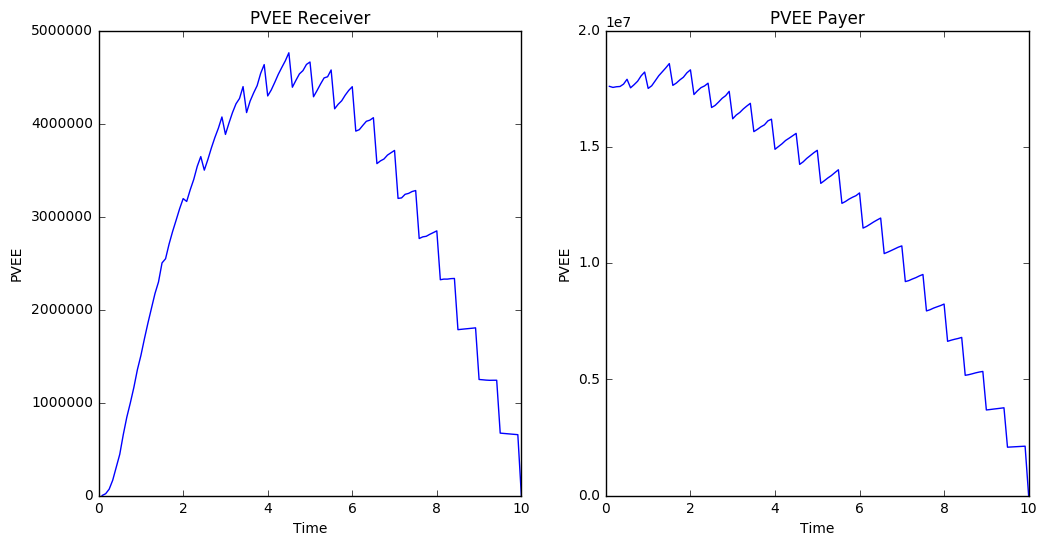

In [5]:
switch_collateral = False
switch_downProv = False
collateral = 0
D = 0
PVEE_payer,EE_payer = calculatePVEE(lbdaBs,lbdaCs,P_OISs,X_Cs,prices_payer,switch_collateral,switch_downProv,collateral,D)
PVEE_receiver,EE_receiver = calculatePVEE(lbdaBs,lbdaCs,P_OISs,X_Cs,prices_receiver,switch_collateral,switch_downProv,collateral,D)
#print "Payer",PVEE_payer
#print "Receiver",PVEE_receiver

plt.figure(figsize=[12,6])
plt.subplot(1,2,1)
plt.plot(ts,PVEE_receiver)
plt.xlabel('Time')
plt.ylabel('PVEE')
plt.title('PVEE Receiver')

plt.subplot(1,2,2)
plt.plot(ts,PVEE_payer)
plt.xlabel('Time')
plt.ylabel('PVEE')
plt.title('PVEE Payer')


plt.savefig('3_1.png')
plt.show()

##### 2 The unilateral CVA from the perspective of B for both payer and receiver swap

In [6]:
CVA_uni_payer = calculateUniCVA(EE_payer,P_OISs,X_Cs,lbdaCs,rr)
CVA_uni_receiver = calculateUniCVA(EE_receiver,P_OISs,X_Cs,lbdaCs,rr)
print "Unilateral CVA as a payer for B is", CVA_uni_payer
print "Unilateral CVA as a receiver for B is",CVA_uni_receiver

Unilateral CVA as a payer for B is 24154053.9417
Unilateral CVA as a receiver for B is 5527176.44162


##### 3 The unilateral DVA from the perspective of B for both payer and receiver swap, net unilateral CVA

In [7]:
DVA_uni_payer = calculateUniDVA(EE_payer,P_OISs,X_Bs,lbdaBs,rr)
DVA_uni_receiver = calculateUniDVA(EE_receiver,P_OISs,X_Bs,lbdaBs,rr)
print "Unilateral DVA as a payer for B is", DVA_uni_payer
print "Unilateral DVA as a receiver for B is",DVA_uni_receiver

net_uni_CVA_payer = calculateNetUniCVA(CVA_uni_payer,DVA_uni_payer)
net_uni_CVA_receiver = calculateNetUniCVA(CVA_uni_receiver,DVA_uni_receiver)
print "Net Unilateral CVA as a payer for B is", net_uni_CVA_payer
print "Net Unilateral CVA as a receiver for B is",net_uni_CVA_receiver

Unilateral DVA as a payer for B is 8685378.04369
Unilateral DVA as a receiver for B is 2029735.41657
Net Unilateral CVA as a payer for B is 15468675.898
Net Unilateral CVA as a receiver for B is 3497441.02505


##### 4 For the receiver swap, graph the unilateral CVA, DVA, and net CVA against the interest rate model parameters $\sigma_r$ and $\kappa_2$ (two separate graphs)

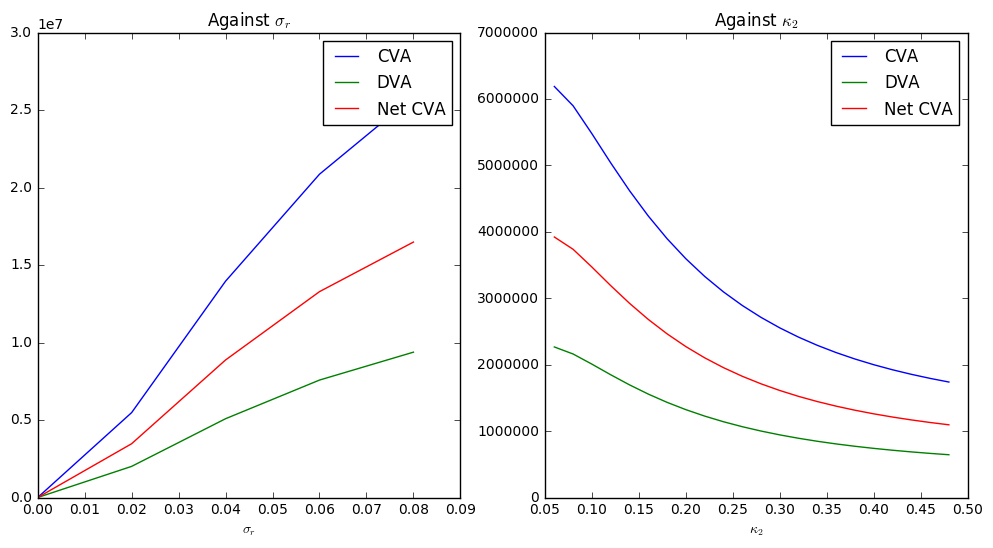

In [5]:
switch_collateral = False
switch_downProv = False
collateral = 0
D = 0
### sigma_r
sigma_rs = np.arange(0,0.1,0.02)
num_sim = 1000
uniCVA_4s = []
uniDVA_4s = []
netCVA_4s = []
for i in range(len(sigma_rs)):
    sigma_l_4 = c * sigma_rs[i]
    sigma1_4 = sigma_l_4
    sigma2_4 = nu*sigma1_4
    P_OISs_4 = []
    #P_LIBORs_4 = []
    prices_receiver_4 = []
    for j in range(num_sim):
        P_OIS, P_LIBOR = simulateOIS(rho_x, sigma1_4, sigma2_4, kappa1, kappa2, sim_freq, maturity, f0_OIS, spread,ts,Tis,wts[j])
        #X_B,X_C,lbdaB,lbdaC = simulateSurvivalProb(lbda0_B,lbda0_C,ts,sigmaB,kappaB,sigmaC,kappaC,wt)
        price_one_path=[]
        for t in range(maturity*sim_freq):
            p =priceSwap(swap, 'receiver', P_OIS, P_LIBOR, t, ts, Tis,sim_freq)
            price_one_path.append(p)
        
        prices_receiver_4.append(price_one_path)
        P_OISs_4.append(P_OIS)
        #P_LIBORs_4.append(P_LIBOR)
        
    PVEE_4,EE_4 = calculatePVEE(lbdaBs,lbdaCs,P_OISs_4,X_Cs,prices_receiver_4,switch_collateral,switch_downProv,collateral,D)
    uniCVA = calculateUniCVA(EE_4,P_OISs_4,X_Cs,lbdaCs,rr)
    uniDVA = calculateUniDVA(EE_4,P_OISs_4,X_Bs,lbdaBs,rr)
    netCVA = calculateNetUniCVA(uniCVA,uniDVA)
    uniCVA_4s.append(uniCVA)
    uniDVA_4s.append(uniDVA)
    netCVA_4s.append(netCVA)

    
### kappa_2
kappa2s = np.arange(0.06,0.5,0.02)
uniCVA_4k = []
uniDVA_4k = []
netCVA_4k = []
for i in range(len(kappa2s)):
    
    P_OISs_4k = []
    #P_LIBORs_4k = []
    prices_receiver_4k = []
    for j in range(num_sim):
        P_OIS, P_LIBOR = simulateOIS(rho_x, sigma1, sigma2, kappa1, kappa2s[i], sim_freq, maturity, f0_OIS, spread,ts,Tis,wts[j])
        #X_B,X_C,lbdaB,lbdaC = simulateSurvivalProb(lbda0_B,lbda0_C,ts,sigmaB,kappaB,sigmaC,kappaC,wt)
        price_one_path=[]
        for t in range(maturity*sim_freq):
            p =priceSwap(swap, 'receiver', P_OIS, P_LIBOR, t, ts, Tis,sim_freq)
            price_one_path.append(p)
        
        prices_receiver_4k.append(price_one_path)
        P_OISs_4k.append(P_OIS)
        #P_LIBORs_4k.append(P_LIBOR)
        
    PVEE_4k,EE_4k = calculatePVEE(lbdaBs,lbdaCs,P_OISs_4k,X_Cs,prices_receiver_4k,switch_collateral,switch_downProv,collateral,D)
    uniCVA = calculateUniCVA(EE_4k,P_OISs_4k,X_Cs,lbdaCs,rr)
    uniDVA = calculateUniDVA(EE_4k,P_OISs_4k,X_Bs,lbdaBs,rr)
    netCVA = calculateNetUniCVA(uniCVA,uniDVA)
    uniCVA_4k.append(uniCVA)
    uniDVA_4k.append(uniDVA)
    netCVA_4k.append(netCVA)

    
### plot 
plt.figure(figsize=[12,6])
plt.subplot(1,2,1)
plt.plot(sigma_rs,uniCVA_4s,sigma_rs,uniDVA_4s,sigma_rs,netCVA_4s)
plt.title('Against $\sigma_r$')
plt.xlabel('$\sigma_r$')
plt.legend(['CVA','DVA','Net CVA'])

plt.subplot(1,2,2)
plt.plot(kappa2s,uniCVA_4k,kappa2s,uniDVA_4k,kappa2s,netCVA_4k)
plt.title('Against $\kappa_2$')
plt.xlabel('$\kappa_2$')
plt.legend(['CVA','DVA','Net CVA'])
plt.savefig('3_4.png')
plt.show()

##### 5 correlations that control wrong- and right-way risk

In [8]:
param = np.arange(-1.,1.,0.05)
rhos = np.array([rho_Bf, rho_Cf,rho_BC,rho_Br, rho_Cr])
all_rhos = []
CVAs = []
num_sim = 500
for i in range(len(rhos)):
    rhos = np.array([rho_Bf, rho_Cf,rho_BC,rho_Br, rho_Cr])
    rho_this = []
    CVA_this = []
    for tester in param:
        rhos[i] = tester
        rho_B1_t = rhos[0]  # corr b/w lbdaB and x1
        rho_C1_t = rhos[1]   # corr b/w lbdaC and x1
        rho_B2_t = rhos[3]*np.sqrt(nu*nu+1.+2*rho_x*nu)-nu*rho_B1_t   # corr b/w lbdaB and x2
        rho_C2_t = rhos[4]*np.sqrt(nu*nu+1.+2*rho_x*nu)-nu*rho_C1_t   # corr b/w lbdaC and x2

        ### correlation matrix among lbdaB,lbdaC,x1,x2 for simulation
        corr = np.array([[1., rhos[2], rho_B1_t, rho_B2_t],\
                 [rhos[2], 1., rho_C1_t, rho_C2_t],\
                 [rho_B1_t, rho_C1_t, 1., rho_x],\
                 [rho_B2_t, rho_C2_t, rho_x, 1.]])
        if np.all(np.linalg.eigvals(corr) >= 0): # make sure corr is positive semi-definite
            chol = np.linalg.cholesky(corr)
            rho_this.append(tester)
            prices_receiver_t = []
            P_OISs_t = []
            X_Cs_t = []
            lbdaBs_t = []
            lbdaCs_t = []
            for num in range(num_sim):
                # simulate correlated 4-D brownian motion
                wt = chol.dot(np.random.normal(0,1./sim_freq,(4,sim_freq*maturity)))
                P_OIS, P_LIBOR = simulateOIS(rho_x, sigma1, sigma2, kappa1, kappa2, sim_freq, maturity, f0_OIS, spread,ts,Tis,wt)
                X_B,X_C,lbdaB,lbdaC = simulateSurvivalProb(lbda0_B,lbda0_C,ts,sigmaB,kappaB,sigmaC,kappaC,wt)
                price_one_path=[]
                for j in range(maturity*sim_freq):
                    p =priceSwap(swap, 'receiver', P_OIS, P_LIBOR, j, ts, Tis,sim_freq)
                    price_one_path.append(p)
        
                prices_receiver_t.append(price_one_path)
                P_OISs_t.append(P_OIS)
                X_Cs_t.append(X_C)
                lbdaCs_t.append(lbdaC)
                lbdaBs_t.append(lbdaB)

            PVEE_receiver_t,EE_receiver_t = calculatePVEE(lbdaBs_t,lbdaCs_t,P_OISs_t,X_Cs,prices_receiver_t,switch_collateral,switch_downProv,collateral,D)
            CVA_uni_receiver_t = calculateUniCVA(EE_receiver_t,P_OISs_t,X_Cs_t,lbdaCs_t,rr)
            CVA_this.append(CVA_uni_receiver_t)
    all_rhos.append(rho_this)
    CVAs.append(CVA_this)

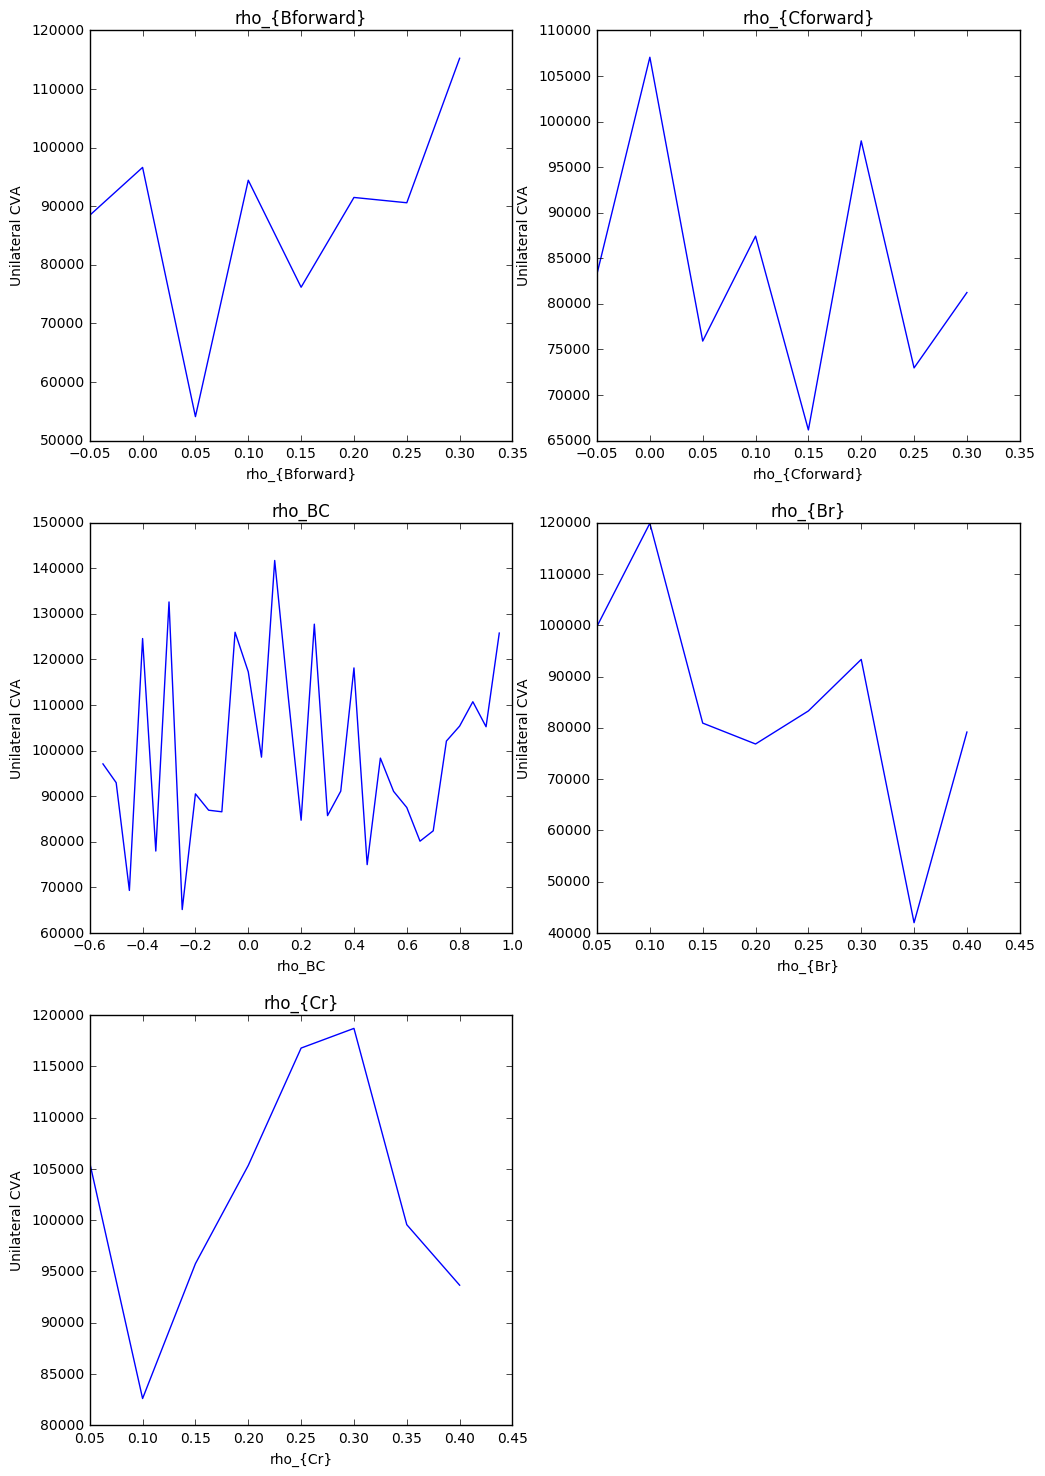

In [10]:
## plot
titles = ['rho_{Bforward}', 'rho_{Cforward}','rho_BC','rho_{Br}', 'rho_{Cr}']
plt.figure(figsize=[12,18])
for i in range(len(all_rhos)):
    
    plt.subplot(3,2,i+1)
    plt.plot(all_rhos[i],CVAs[i])
    plt.title(titles[i])
    plt.ylabel('Unilateral CVA')
    plt.xlabel(titles[i])

plt.savefig('3_5.png')
plt.show()

In [70]:
# change cforward and cr only simultaneously

param = np.arange(-1.,1.,0.2)
rhos = np.array([rho_Bf, rho_Cf,rho_BC,rho_Br, rho_Cr])
#all_rhos = []
cfs = []
crs = []
CVAs = []
num_sim = 100
for cf in param:
    rhos = np.array([rho_Bf, cf,rho_BC,rho_Br, rho_Cr])
    #rho_this = []
    #CVA_this = []
    for cr in param:
        rhos[4] = cr
        rho_B1_t = rhos[0]  # corr b/w lbdaB and x1
        rho_C1_t = rhos[1]   # corr b/w lbdaC and x1
        rho_B2_t = rhos[3]*np.sqrt(nu*nu+1.+2*rho_x*nu)-nu*rho_B1_t   # corr b/w lbdaB and x2
        rho_C2_t = rhos[4]*np.sqrt(nu*nu+1.+2*rho_x*nu)-nu*rho_C1_t   # corr b/w lbdaC and x2

        ### correlation matrix among lbdaB,lbdaC,x1,x2 for simulation
        corr = np.array([[1., rhos[2], rho_B1_t, rho_B2_t],\
                 [rhos[2], 1., rho_C1_t, rho_C2_t],\
                 [rho_B1_t, rho_C1_t, 1., rho_x],\
                 [rho_B2_t, rho_C2_t, rho_x, 1.]])
        if np.all(np.linalg.eigvals(corr) >= 0): # make sure corr is positive semi-definite
            chol = np.linalg.cholesky(corr)
            #rho_this.append(tester)
            prices_receiver_t = []
            P_OISs_t = []
            X_Cs_t = []
            lbdaBs_t = []
            lbdaCs_t = []
            for num in range(num_sim):
                # simulate correlated 4-D brownian motion
                wt = chol.dot(np.random.normal(0,1./sim_freq,(4,sim_freq*maturity)))
                P_OIS, P_LIBOR = simulateOIS(rho_x, sigma1, sigma2, kappa1, kappa2, sim_freq, maturity, f0_OIS, spread,ts,Tis,wt)
                X_B,X_C,lbdaB,lbdaC = simulateSurvivalProb(lbda0_B,lbda0_C,ts,sigmaB,kappaB,sigmaC,kappaC,wt)
                price_one_path=[]
                for j in range(maturity*sim_freq):
                    p =priceSwap(swap, 'receiver', P_OIS, P_LIBOR, j, ts, Tis,sim_freq)
                    price_one_path.append(p)
        
                prices_receiver_t.append(price_one_path)
                P_OISs_t.append(P_OIS)
                X_Cs_t.append(X_C)
                lbdaCs_t.append(lbdaC)
                lbdaBs_t.append(lbdaB)

            PVEE_receiver_t,EE_receiver_t = calculatePVEE(lbdaBs_t,lbdaCs_t,P_OISs_t,X_Cs,prices_receiver_t,switch_collateral,switch_downProv,collateral,D)
            CVA_uni_receiver_t = calculateUniCVA(EE_receiver_t,P_OISs_t,X_Cs_t,lbdaCs_t,rr)
            CVAs.append(CVA_uni_receiver_t)
            cfs.append(cf)
            crs.append(cr)
            
    

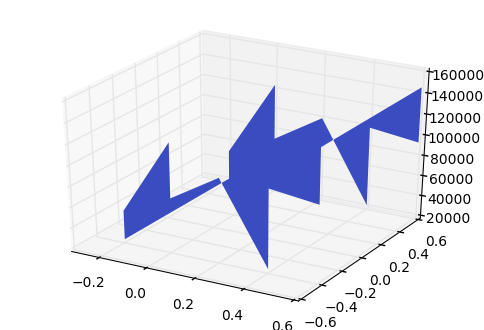

In [72]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
a,b = np.meshgrid(crs,cfs)
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(a,b,CVAs,cmap=cm.coolwarm,linewidth=0, antialiased=False)
plt.savefig('3_5_2.png')
plt.show()

###### Explanation:
We can see from the graphs above,

##### 6 with credit mitigants Repeat Exercise 1

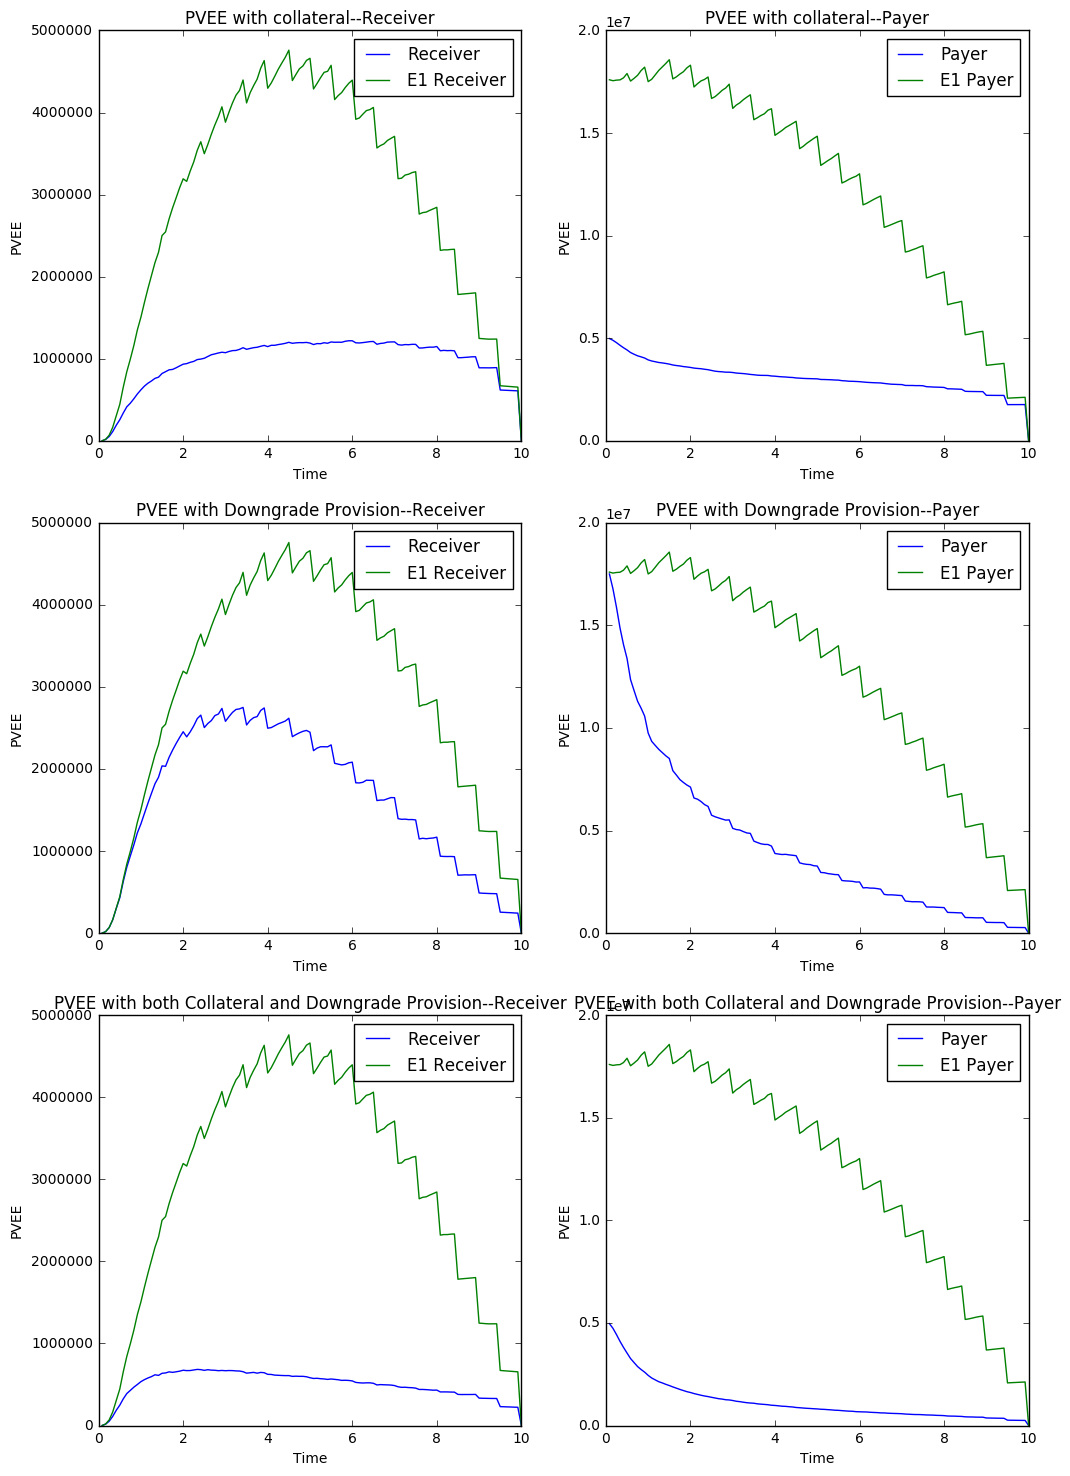

In [8]:
## a) with collateral
switch_collateral = True
collateral = 5000000.
PVEE_payer_col,EE_payer_col = calculatePVEE(lbdaBs,lbdaCs,P_OISs,X_Cs,prices_payer,switch_collateral,switch_downProv,collateral,D)
PVEE_receiver_col,EE_receiver_col = calculatePVEE(lbdaBs,lbdaCs,P_OISs,X_Cs,prices_receiver,switch_collateral,switch_downProv,collateral,D)
#print "Payer",PVEE_payer
#print "Receiver",PVEE_receiver

plt.figure(figsize=[12,18])
plt.subplot(3,2,1)
plt.plot(ts,PVEE_receiver_col,ts,PVEE_receiver)
plt.xlabel('Time')
plt.ylabel('PVEE')
plt.title('PVEE with collateral--Receiver')
plt.legend(['Receiver','E1 Receiver'],loc='best')

plt.subplot(3,2,2)
plt.plot(ts,PVEE_payer_col,ts,PVEE_payer)
plt.xlabel('Time')
plt.ylabel('PVEE')
plt.title('PVEE with collateral--Payer')
plt.legend(['Payer','E1 Payer'],loc='best')


## b) with termination
switch_collateral = False
collateral = 0
switch_downProv = True
D = 0.0375
PVEE_payer_down,EE_payer_down = calculatePVEE(lbdaBs,lbdaCs,P_OISs,X_Cs,prices_payer,switch_collateral,switch_downProv,collateral,D)
PVEE_receiver_down,EE_receiver_down = calculatePVEE(lbdaBs,lbdaCs,P_OISs,X_Cs,prices_receiver,switch_collateral,switch_downProv,collateral,D)


plt.subplot(3,2,3)
plt.plot(ts,PVEE_receiver_down,ts,PVEE_receiver)
plt.xlabel('Time')
plt.ylabel('PVEE')
plt.title('PVEE with Downgrade Provision--Receiver')
plt.legend(['Receiver','E1 Receiver'],loc='best')

plt.subplot(3,2,4)
plt.plot(ts,PVEE_payer_down,ts,PVEE_payer)
plt.xlabel('Time')
plt.ylabel('PVEE')
plt.title('PVEE with Downgrade Provision--Payer')
plt.legend(['Payer','E1 Payer'],loc='best')

## c) with both collateral and termination
switch_collateral = True
collateral = 5000000.
PVEE_payer_both,EE_payer_both = calculatePVEE(lbdaBs,lbdaCs,P_OISs,X_Cs,prices_payer,switch_collateral,switch_downProv,collateral,D)
PVEE_receiver_both,EE_receiver_both = calculatePVEE(lbdaBs,lbdaCs,P_OISs,X_Cs,prices_receiver,switch_collateral,switch_downProv,collateral,D)
#print "Payer",PVEE_payer
#print "Receiver",PVEE_receiver

plt.subplot(3,2,5)
plt.plot(ts,PVEE_receiver_both,ts,PVEE_receiver)
plt.xlabel('Time')
plt.ylabel('PVEE')
plt.title('PVEE with both Collateral and Downgrade Provision--Receiver')
plt.legend(['Receiver','E1 Receiver'],loc='best')

plt.subplot(3,2,6)
plt.plot(ts,PVEE_payer_both,ts,PVEE_payer)
plt.xlabel('Time')
plt.ylabel('PVEE')
plt.title('PVEE with both Collateral and Downgrade Provision--Payer')
plt.legend(['Payer','E1 Payer'],loc='best')
plt.savefig('3_6.png')
plt.show()


##### 7 Compute the bilateral CVA,DVA,net CVA for the naked swap position

In [9]:
bi_CVA_receiver = calculateBiCVA(EE_receiver,P_OISs,X_Cs,lbdaCs,rr,X_Bs)
bi_DVA_receiver = calculateBiDVA(EE_receiver,P_OISs,X_Cs,lbdaBs,rr,X_Bs)
net_bi_CVA_receiver = calculateNetBiCVA(bi_CVA_receiver,bi_DVA_receiver)
bilateral = [bi_CVA_receiver,bi_DVA_receiver,net_bi_CVA_receiver]
unilateral = [CVA_uni_receiver,DVA_uni_receiver,net_uni_CVA_receiver]

df = pd.DataFrame(np.asarray([unilateral,bilateral]),index = ['Unilateral','Bilateral'],columns = ['CVA','DVA','Net CVA'])
fmt.displayDF(df,'4g')

,CVA,DVA,Net CVA
Unilateral,5.527e+06,2.03e+06,3.497e+06
Bilateral,5.27e+06,1.757e+06,3.513e+06


###### Explain the results:
We can see the $CVA_{unilateral}>CVA_{bilateral}$ and $DVA_{unilateral}>DVA_{bilateral} $, this is because when calculating bilateral numbers, there is an extra discount factor of survival probability.

### 4 IMM Exercise

In [10]:
from marketSetup import simulateOIS_IMM,simulateSurvivalProb_IMM
prices_payer_IMM=[]
prices_receiver_IMM = []
P_OISs_IMM = []
#P_LIBORs_IMM = []
#X_Bs_IMM = []
X_Cs_IMM = []
#lbdaBs_IMM = []
lbdaCs_IMM = []
#wts_IMM = []

for num in range(num_simulation):
    # simulate correlated 4-D brownian motion
    wt = chol.dot(np.random.normal(0,1./np.sqrt(sim_freq),(4,sim_freq*maturity)))
    #wts.append(wt)
    P_OIS, P_LIBOR = simulateOIS_IMM(rho_x, sigma1, sigma2, kappa1, kappa2, sim_freq, maturity, f0_OIS, spread,ts,Tis,wt)
    X_B,X_C,lbdaB,lbdaC = simulateSurvivalProb_IMM(lbda0_B,lbda0_C,ts,sigmaB,kappaB,sigmaC,kappaC,wt)
    price_one_path=[]
    price_one_path_payer = []
    for i in range(maturity*sim_freq):
        p = priceSwap(swap, 'payer', P_OIS, P_LIBOR, i, ts, Tis,sim_freq)
        price_one_path_payer.append(p)
        price_one_path.append(-p)
        
    prices_payer_IMM.append(price_one_path_payer)
    prices_receiver_IMM.append(price_one_path)
    P_OISs_IMM.append(P_OIS)
    #P_LIBORs_IMM.append(P_LIBOR)
    #X_Bs_IMM.append(X_B)
    X_Cs_IMM.append(X_C)
    #lbdaBs_IMM.append(lbdaB)
    lbdaCs_IMM.append(lbdaC)
    
#print "payer",np.average(prices_payer,axis=0)
#print prices_payer

##### 1 Expected Exposure Profile

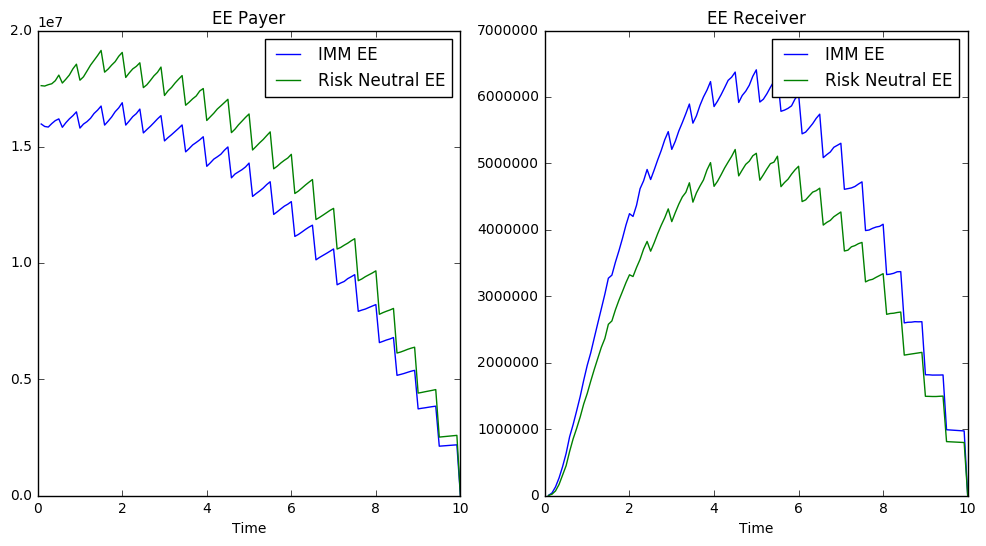

In [11]:
switch_collateral = False
switch_downProv = False
collateral = 0
D = 0
PVEE_payer_IMM,EE_payer_IMM = calculatePVEE(lbdaBs,lbdaCs_IMM,P_OISs_IMM,X_Cs_IMM,prices_payer_IMM,switch_collateral,switch_downProv,collateral,D)
PVEE_receiver_IMM,EE_receiver_IMM = calculatePVEE(lbdaBs,lbdaCs_IMM,P_OISs_IMM,X_Cs_IMM,prices_receiver_IMM,switch_collateral,switch_downProv,collateral,D)

plt.figure(figsize=[12,6])
plt.subplot(1,2,1)
plt.plot(ts,EE_payer_IMM,ts,EE_payer)
plt.xlabel('Time')
plt.legend(['IMM EE','Risk Neutral EE'])
plt.title('EE Payer')
plt.subplot(1,2,2)
plt.plot(ts,EE_receiver_IMM,ts,EE_receiver)
plt.xlabel('Time')
plt.legend(['IMM EE','Risk Neutral EE'])
plt.title('EE Receiver')
plt.savefig('4_1.png')
plt.show()


##### 2 Calculate EEPE, EAD, M

In [12]:
from IMM_fun import CalcEAD,RegulatoryCapital,EffectiveMaturity,CalcEEPE

alpha = 1.4
LGD = 0.4
PD = 0.01
# EEPE
EEPE_payer = CalcEEPE(EE_payer,sim_freq)
EEPE_receiver = CalcEEPE(EE_receiver,sim_freq)

# EAD
## Basel 2 EAD
EAD_payer_2 = CalcEAD('2',EEPE_payer,0,alpha,sim_freq)
EAD_receiver_2 = CalcEAD('2',EEPE_receiver,0,alpha,sim_freq)
'''## Basel 3 EAD
CVA_uni_payer_IMM = calculateUniCVA(EE_payer_IMM,P_OISs_IMM,X_Cs_IMM,lbdaCs_IMM,rr)
CVA_uni_receiver_IMM = calculateUniCVA(EE_receiver_IMM,P_OISs_IMM,X_Cs_IMM,lbdaCs_IMM,rr)
EAD_payer_3 = CalcEAD('3',EEPE_payer,CVA_uni_payer_IMM,alpha,sim_freq)
EAD_receiver_3 = CalcEAD('3',EEPE_receiver,CVA_uni_receiver_IMM,alpha,sim_freq)
print CVA_uni_receiver_IMM'''


# Effectvie Maturity
M_payer = EffectiveMaturity(EE_payer_IMM,sim_freq,P_OISs_IMM)
M_receiver = EffectiveMaturity(EE_receiver_IMM,sim_freq,P_OISs_IMM)

#df_payer = np.asarray([EEPE_payer,EAD_payer_2,EAD_payer_3,M_payer])
#df_receiver = np.asarray([EEPE_receiver,EAD_receiver_2,EAD_receiver_3,M_receiver])
#inds = ['EEPE','EAD(Basel 2)','EAD(Basel 3)','Maturity']
df_payer = np.asarray([EEPE_payer,EAD_payer_2,M_payer])
df_receiver = np.asarray([EEPE_receiver,EAD_receiver_2,M_receiver])
inds = ['EEPE','EAD(Basel 2)','Maturity']

df2 = pd.DataFrame([df_payer, df_receiver],index = ['Payer','Receiver'],columns=inds)
fmt.displayDF(df2,'4g')


,EEPE,EAD(Basel 2),Maturity
Payer,1.802e+07,2.523e+07,1.652
Receiver,6.357e+05,8.9e+05,5


##### 3 Regulatory Capital

In [13]:
RC_payer = RegulatoryCapital(EAD_payer_2,M_payer,LGD,PD)
RC_receiver = RegulatoryCapital(EAD_receiver_2,M_receiver,LGD,PD)

print "Regulatory Capital for payer is",RC_payer
print "Regulatory Capital for Receiver is",RC_receiver

Regulatory Capital for payer is 1575406.2666
Regulatory Capital for Receiver is 84538.1772223
